# Car Price Prediction Using Linear Regression
---

### Base Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. The Dataset
https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

- 205 examples
- 25 features: Numerical and categorical
- Target: 'price'

In [2]:
df = pd.read_csv("CarPrice_Assignment.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

# 2. Data Preprocessing

## 2.1 Numerical Features

In [3]:
num_features = df.select_dtypes(include=['float64', 'int64'])
num_features = num_features.drop(columns=['price'])

print(num_features.columns)

Index(['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')


In [4]:
df = df.drop(columns=["car_ID"])

## 2.2 Categorical Features

In [5]:
cat_features = df.select_dtypes(include=['object'])
cat_features.apply(lambda feature: feature.unique())

CarName           [alfa-romero giulia, alfa-romero stelvio, alfa...
fueltype                                              [gas, diesel]
aspiration                                             [std, turbo]
doornumber                                              [two, four]
carbody             [convertible, hatchback, sedan, wagon, hardtop]
drivewheel                                          [rwd, fwd, 4wd]
enginelocation                                        [front, rear]
enginetype                 [dohc, ohcv, ohc, l, rotor, ohcf, dohcv]
cylindernumber         [four, six, five, three, twelve, two, eight]
fuelsystem           [mpfi, 2bbl, mfi, 1bbl, spfi, 4bbl, idi, spdi]
dtype: object

### 2.2.1 Transformations

In [6]:
df['brand'] = df.CarName.apply(lambda x: x.split(" ")[0])
print("Before:", np.sort(df.brand.unique()))

df = (df.replace("Nissan", "nissan")
  .replace("vokswagen", "volkswagen").replace("vw", "volkswagen")
  .replace("toyouta", "toyota").replace("maxda", "mazda")
  .replace("porcshce", "porsche").replace("alfa-romero", "alfa-romeo"))

df = df.drop(columns=["CarName"])
print("After:", np.sort(df.brand.unique()))

Before: ['Nissan' 'alfa-romero' 'audi' 'bmw' 'buick' 'chevrolet' 'dodge' 'honda'
 'isuzu' 'jaguar' 'maxda' 'mazda' 'mercury' 'mitsubishi' 'nissan'
 'peugeot' 'plymouth' 'porcshce' 'porsche' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'volvo' 'vw']
After: ['alfa-romeo' 'audi' 'bmw' 'buick' 'chevrolet' 'dodge' 'honda' 'isuzu'
 'jaguar' 'mazda' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


### 2.2.2 Encoding

In [7]:
# Label Encoding
label_encode = ['aspiration','enginelocation','doornumber','fueltype','drivewheel']
df[label_encode] = df[label_encode].apply(lambda x: pd.factorize(x)[0])

# One-hot encoding
df = pd.get_dummies(df)

In [8]:
print(f"Total number of features:", len(df.columns)-1)

Total number of features: 68


# 3. Model Evaluation and Scoring

## 3.1 Feature Selection

### 3.1.1 Top and Worst features by correlation with price

In [9]:
X = df.drop(columns=['price'])
y = df.price
X_by_corr = X.corrwith(y).abs().sort_values(ascending=False)

print("Top 10 Features:")
print(X_by_corr[:10].round(3))
print("\nWorst 10 Features:")
print(X_by_corr[-10:].sort_values().round(3))

Top 10 Features:
enginesize             0.874
curbweight             0.835
horsepower             0.808
carwidth               0.759
cylindernumber_four    0.698
highwaympg             0.698
citympg                0.686
carlength              0.683
drivewheel             0.578
wheelbase              0.578
dtype: float64

Worst 10 Features:
fuelsystem_mfi        0.003
cylindernumber_two    0.005
enginetype_rotor      0.005
enginetype_ohcf       0.016
fuelsystem_4bbl       0.017
fuelsystem_spfi       0.020
brand_mercury         0.028
doornumber            0.032
brand_alfa-romeo      0.034
enginetype_l          0.042
dtype: float64


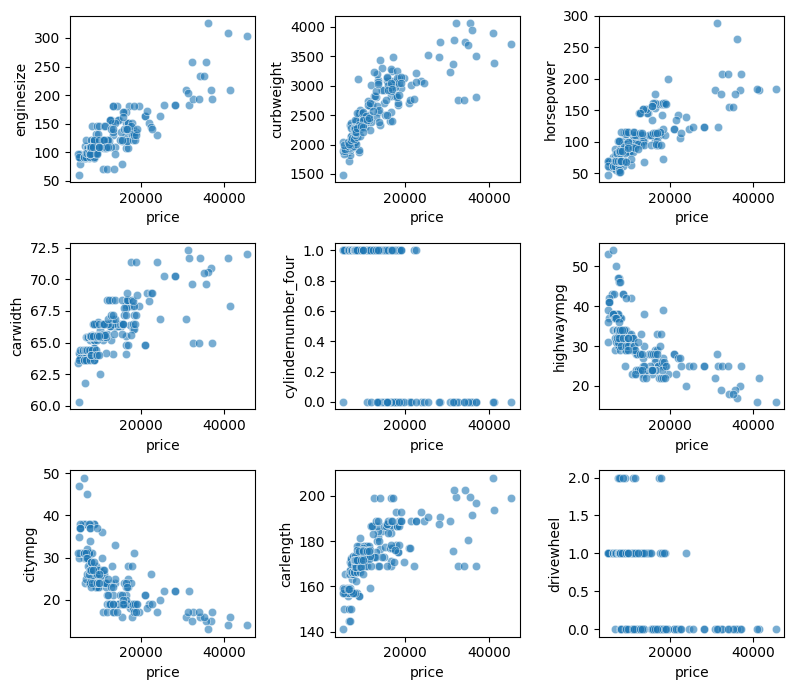

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(8,7))
axes = axes.flatten()
for (i, col) in enumerate(X_by_corr.index[:9]):
  sns.scatterplot(x=df.price, y=df[col], ax=axes[i], alpha=0.6)
plt.tight_layout()
plt.show()

### 3.1.2 Finding optimal number of features

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold

def apply_cross_validation(X, y, kfolds=10):
  model = LinearRegression()
  kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
  scores = ['r2', 'neg_root_mean_squared_error']
  results = cross_validate(model, X, y, cv=kf, scoring=scores)
  return np.mean(results['test_r2']), -np.mean(results['test_neg_root_mean_squared_error'])


results = {"i": [], "rmse":[], "r2":[]}

for i in range(2, len(X_by_corr)):
  new_X = X[X_by_corr.index[:i]]
  r2, rmse = apply_cross_validation(new_X, y)
  results["i"].append(i)
  results["rmse"].append(rmse)
  results["r2"].append(r2)

results = pd.DataFrame(results)

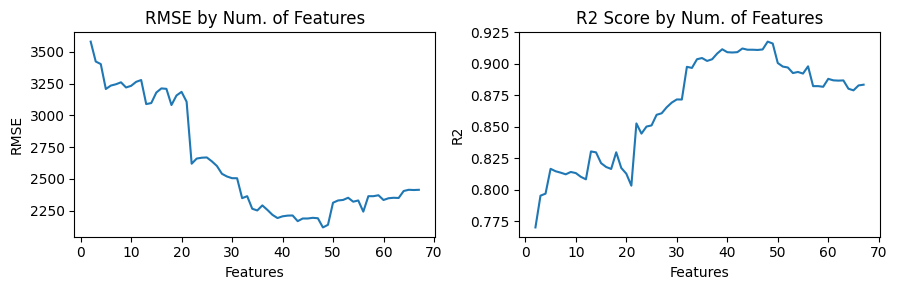

In [12]:
# Plot evaluation results
fig, axes = plt.subplots(1, 2, figsize=(9,3))
axes[0].plot(results.i, results.rmse, linestyle='-')
axes[1].plot(results.i, results.r2, linestyle='-')
axes[0].set_xlabel('Features')
axes[1].set_xlabel('Features')
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('R2')
axes[0].set_title('RMSE by Num. of Features')
axes[1].set_title('R2 Score by Num. of Features')
plt.tight_layout()
plt.show()

In [13]:
best = results[results.rmse == results.rmse.min()]
X = X[X_by_corr.index[:best.i.iloc[0]]]

print(f"Optimal number of top correlated features is {best.i.iloc[0]} with R2={best.r2.iloc[0]:.3f} and RMSE={best.rmse.iloc[0]:.2f}")

Optimal number of top correlated features is 48 with R2=0.918 and RMSE=2118.16


## 3.2 Train and Test

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Test
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test result: RMSE={rmse:.2f}, R2_Score={r2:.3f}")

Test result: RMSE=2515.90, R2_Score=0.920


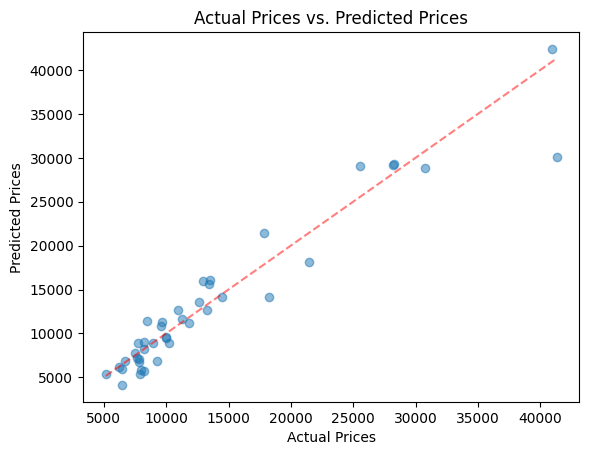

In [15]:
# Predicted vs Actual
from_to = [min(y_test), max(y_test)]
plt.plot(from_to, from_to, color='red', linestyle='--', alpha=0.5)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs. Predicted Prices")
plt.show()